# YamboRestart: a G0W0 run with error handling and automatic input creation

This is the lowest-level workflow of the plugin. It runs a yambo calculation (p2y+yambo) and, at variance with respect to the simple `YamboCalculation` providing ***automatic error handling***.
Another difference is that, here, we can populate the inputs with default values. This is achieved via the `get_builder_from_protocol` method of the workchain.

In [1]:
from aiida import orm, load_profile
load_profile()

Profile<uuid='3745313b017b418697d37cbf16c4e7ef' name='generic'>

The creation of the builder, for a given workflow, is provided by means of the `get_builder_from_protocol` method.
This is, for now, just a way to automatically populated all the needed inputs, allowing the user to partially skip the part of input definition.

However, for GW and BSE simulation, default parameter values for a given level of accuracy are not really tested, so the user should check carefully them before the submission of the simulation.

In [2]:
from aiida.plugins import WorkflowFactory
YamboRestart = WorkflowFactory('yambo.yambo.yamborestart')

## Providing the minimal inputs needed for protocols

We have to provide minimal inputs for the creation of the builder instance, namely:
- codes;
- `parent_folder`;

In [ ]:
import yaml,io

# Read YAML file
with open("../configuration/codes_localhost.yaml", 'r') as stream:
    codes = yaml.safe_load(stream)
    
with open("../configuration/resources_localhost.yaml", 'r') as stream:
    resources = yaml.safe_load(stream)

In [3]:
options = {
    'protocol':'fast',
    'parent_id':379, #take your previously nscf id (pk)
}

In [ ]:
options.update(codes)

In [4]:
#YamboRestart.get_builder_from_protocol??

In [5]:
builder = YamboRestart.get_builder_from_protocol(
            preprocessing_code = options['yamboprecode_id'],
            code = options['yambocode_id'],
            protocol=options['protocol'],
            overrides={},
            parent_folder=orm.load_node(options['parent_id']).outputs.remote_folder,
            RIM_v=False,           #this automatically set RIM_cut, if True
            RIM_W=False,           #this automatically set RIM_W, if True
            BG_term=False,         #this automatically set BG terminator, if True
)

Summary of the main inputs:
BndsRnXp = 200
GbndRnge = 200
NGsBlkXp = 6 Ry
FFTGvecs = 21 Ry



You can also inspect the other protocols which are available: 

In [6]:
YamboRestart.get_available_protocols()

{'fast': {'description': 'Under converged for most materials, but fast'},
 'moderate': {'description': 'Meta converged for most materials, higher computational cost than fast'},
 'precise': {'description': 'Converged for most materials, higher computational cost than moderate'},
 'bse_fast': {'description': 'Under converged for most materials, but fast'},
 'bse_moderate': {'description': 'Meta converged for most materials, higher computational cost than fast'},
 'bse_precise': {'description': 'Converged for most materials, higher computational cost than moderate'}}

Now, if you inspect the pre populated inputs, you can see the default values respecting the imposed protocol:

In [7]:
builder.yambo.parameters.get_dict()

{'arguments': ['dipoles', 'ppa', 'HF_and_locXC', 'gw0'],
 'variables': {'Chimod': 'hartree',
  'DysSolver': 'n',
  'GTermKind': 'BG',
  'X_and_IO_nCPU_LinAlg_INV': [1, ''],
  'NGsBlkXp': [6, 'Ry'],
  'FFTGvecs': [21, 'Ry'],
  'BndsRnXp': [[1, 200], ''],
  'GbndRnge': [[1, 200], ''],
  'QPkrange': [[[1, 1, 32, 32]], '']}}

Let's provide also the resources:

In [10]:
builder.yambo.metadata.options = resources

### Overrides

It is possible to modify the default inputs also during the builder creation phase, so not a posteriori. This can be done by using overrides:

In [11]:
overrides_yambo = {
        "yambo": {
            "parameters": {
                "arguments": [
                    "rim_cut",
                ],
                "variables": {
                    "NGsBlkXp": [4, "Ry"],
                },
            },
    'metadata':resources,
        }
}

In [12]:
builder = YamboRestart.get_builder_from_protocol(
            preprocessing_code = options['yamboprecode_id'],
            code = options['yambocode_id'],
            protocol=options['protocol'],
            overrides=overrides_yambo,
            parent_folder=orm.load_node(options['parent_id']).outputs.remote_folder,
)

Summary of the main inputs:
BndsRnXp = 200
GbndRnge = 200
NGsBlkXp = 4 Ry
FFTGvecs = 21 Ry



In [13]:
builder.yambo.metadata.options

{'stash': {}, 'resources': {'num_machines': 1, 'num_mpiprocs_per_machine': 1, 'num_cores_per_mpiproc': 1}, 'max_wallclock_seconds': 3600, 'withmpi': True, 'prepend_text': 'export OMP_NUM_THREADS=1'}

In [14]:
builder.yambo.parameters.get_dict()

{'arguments': ['gw0', 'ppa', 'HF_and_locXC', 'rim_cut', 'dipoles'],
 'variables': {'Chimod': 'hartree',
  'DysSolver': 'n',
  'GTermKind': 'BG',
  'X_and_IO_nCPU_LinAlg_INV': [1, ''],
  'NGsBlkXp': [4, 'Ry'],
  'FFTGvecs': [21, 'Ry'],
  'BndsRnXp': [[1, 200], ''],
  'GbndRnge': [[1, 200], ''],
  'QPkrange': [[[1, 1, 32, 32]], '']}}

### Submission phase

In [15]:
from aiida.engine import submit

In [16]:
run = None

In [17]:
if run:
    print('run is already running -> {}'.format(run.pk))
    print('sure that you want to run again?, if so, copy the else instruction in the cell below and run!')
else:
    run = submit(builder)

print(run)

uuid: d81d42bd-eb63-4869-abfe-60a168dbe4e5 (pk: 414) (aiida.workflows:yambo.yambo.yamborestart)


# Inspecting the outputs

Suppose that your calculation completed successfully, then you can access the outputs via the output method of the run instance. 
This is analogous to the *1_YamboCalculation_G0W0* module, as the outputs are really the same.

In [19]:
run.is_finished_ok

True

In [20]:
run.outputs. #+TAB

SyntaxError: invalid syntax (708973465.py, line 1)

For example, we have the array_ndb ArrayData, which essentially contains the information on the run.output.QP_DB (which can also be accessed directly):

In [21]:
run.outputs.array_ndb.get_arraynames()

['E',
 'Z',
 'Eo',
 'Sc',
 'Sx',
 'Vxc',
 'Band',
 'Kpoint',
 'nbands',
 'nkpoints',
 'qp_table',
 'E_minus_Eo',
 'Kpoint_index']

In [22]:
E_dft = run.outputs.array_ndb.get_array('Eo') #Ha
E_qp = run.outputs.array_ndb.get_array('E')   #Ha

In [23]:
from matplotlib import pyplot as plt

In [24]:
from ase import units

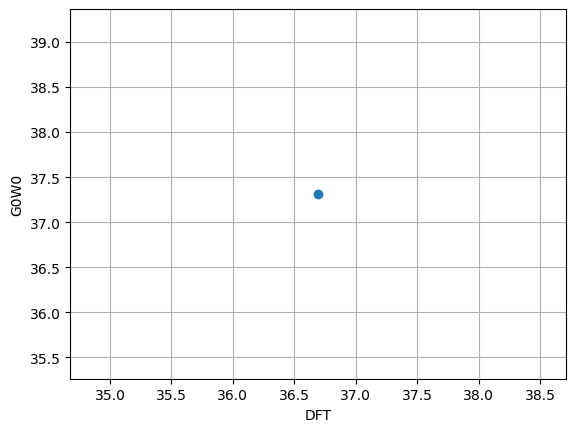

In [25]:
plt.plot(E_dft.real*units.Ha,E_qp.real*units.Ha,'o')
plt.ylabel('G0W0')
plt.xlabel('DFT')
plt.grid()

In [26]:
E_qp

array([1.3712494+0.03359988j], dtype=complex64)

In [27]:
run.outputs.output_parameters.get_dict()

{'errors': [],
 'timing': [' <---> [01] MPI/OPENMP structure, Files & I/O Directories\n',
  ' <---> [02] CORE Variables Setup\n',
  ' <---> [03] Transferred momenta grid and indexing\n',
  ' <---> [04] Dipoles\n',
  ' <04s> [05] Dynamic Dielectric Matrix (PPA)\n',
  ' <26s> [06] Local Exchange-Correlation + Non-Local Fock\n',
  ' <27s> [07] Dyson equation: Newton solver\n',
  ' <28s> [08] Timing Overview\n',
  ' <28s> [09] Game Over & Game summary\n'],
 'has_gpu': False,
 'memstats': [],
 'warnings': [],
 'Fermi(eV)': 0,
 'game_over': True,
 'last_time': 28,
 'para_error': False,
 'time_error': False,
 'ns_db1_path': '/tmp/tmpwqqp53h0',
 'memory_error': False,
 'p2y_completed': True,
 'yambo_version': '5.x',
 'requested_time': 3600,
 'last_time_units': 'seconds',
 'yambo_wrote_dbs': True,
 'corrupted_fragment': False,
 'X_par_allocation_error': False}

In [28]:
run.outputs.QP_db

<SinglefileData: uuid: 65f3632a-e9c9-46e2-85f7-ae87df8b91cc (pk: 418)>

## Error handling in action: the case of walltime exhaustion

You can try the restaring mechanism by asking for a very small time for the simulation, in such a way that the first run will not be completed successfully. 
You can see, by inspecting the report of the run, that the workflow tries to submit other calculation by increasing the time requested.

In [38]:
overrides_yambo = {
        "yambo": {
            "parameters": {
                "arguments": [
                    "rim_cut",
                ],
                "variables": {
                    "NGsBlkXp": [12, "Ry"],
                },
            },
    'metadata':{
                    'options':{
    'max_wallclock_seconds': 10, # in seconds
    'resources': {
            "num_machines": 1, # nodes
            "num_mpiprocs_per_machine": 1, # MPI per nodes
            "num_cores_per_mpiproc": 1, # OPENMP
        },
    'prepend_text': u"export OMP_NUM_THREADS="+str(1), # if needed
    #'account':'project_name',
    #'queue_name':'s3par',
    #'qos':'',
                    },
    },
        }
}

builder = YamboRestart.get_builder_from_protocol(
            preprocessing_code = options['yamboprecode_id'],
            code = options['yambocode_id'],
            protocol=options['protocol'],
            overrides=overrides_yambo,
            parent_folder=orm.load_node(options['parent_id']).outputs.remote_folder,
)

Summary of the main inputs:
BndsRnXp = 200
GbndRnge = 200
NGsBlkXp = 12 Ry
FFTGvecs = 21 Ry



In [39]:
builder.yambo.metadata

{'options': {'stash': {}, 'resources': {'num_machines': 1, 'num_mpiprocs_per_machine': 1, 'num_cores_per_mpiproc': 1}, 'max_wallclock_seconds': 10, 'withmpi': True, 'prepend_text': 'export OMP_NUM_THREADS=1'}}

In [40]:
run = None

In [41]:
if run:
    print('run is already running -> {}'.format(run.pk))
    print('sure that you want to run again?, if so, copy the else instruction in the cell below and run!')
else:
    run = submit(builder)

print(run)

uuid: 79867dd6-0135-4580-bd99-2ef4d7a05b6b (pk: 440) (aiida.workflows:yambo.yambo.yamborestart)


In [42]:
print(run.pk)

440


In [43]:
run.is_finished

False

In [49]:
!verdi process report {run.pk}

2024-01-15 18:16:34 [25 | REPORT]: [440|YamboRestart|run_process]: launching YamboCalculation<441> iteration #1
2024-01-15 18:17:51 [28 | REPORT]: [440|YamboRestart|report_error_handled]: YamboCalculation<441> failed with exit status 501: time exceeded the max walltime
2024-01-15 18:17:51 [29 | REPORT]: [440|YamboRestart|report_error_handled]: Action taken: walltime error detected, so we increase time: 15                                                 seconds and link outputs
2024-01-15 18:17:51 [30 | REPORT]: [440|YamboRestart|inspect_process]: YamboCalculation<441> failed but a handler dealt with the problem, restarting
2024-01-15 18:17:52 [31 | REPORT]: [440|YamboRestart|run_process]: launching YamboCalculation<446> iteration #2
2024-01-15 18:19:23 [34 | REPORT]: [440|YamboRestart|report_error_handled]: YamboCalculation<446> failed with exit status 501: time exceeded the max walltime
2024-01-15 18:19:23 [35 | REPORT]: [440|YamboRestart|report_error_handled]: Action taken: walltime 